#### References:

@InProceedings{maas-EtAl:2011:ACL-HLT2011,<br/>
  &ensp;&ensp;&ensp;author = {Maas, Andrew L. and Daly, Raymond E. and Pham, Peter T. and Huang, Dan and Ng, Andrew Y. and Potts, Christopher},<br/>
  &ensp;&ensp;&ensp;title = {Learning Word Vectors for Sentiment Analysis},<br/>
  &ensp;&ensp;&ensp;booktitle = {Proceedings of the 49th Annual Meeting of the Association for Computational Linguistics: Human Language Technologies},<br/>
  &ensp;&ensp;&ensp;month = {June},<br/>
  &ensp;&ensp;&ensp;year = {2011},<br/>
  &ensp;&ensp;&ensp;address = {Portland, Oregon, USA},<br/>
  &ensp;&ensp;&ensp;publisher = {Association for Computational Linguistics},<br/>
  &ensp;&ensp;&ensp;pages = {142--150},<br/>
  &ensp;&ensp;&ensp;url = {http://www.aclweb.org/anthology/P11-1015}<br/>
}

In [1]:
# common libraries
import joblib
import os
import re
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import string
import tabulate

# natural language toolkit libraries
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
from nltk.corpus import wordnet, stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

# machine learning libraries
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import sklearn.metrics as mtr
from sklearn.naive_bayes import MultinomialNB
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.preprocessing.text import Tokenizer

# bidirectional encoder representations from transformers sentiment analysis
# hugging face ai platforms
from transformers import BertTokenizer, TFBertForSequenceClassification
from transformers import InputExample, InputFeatures

# files
from contractions import CONTRACTION_MAP

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\dejon\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dejon\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\dejon\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\dejon\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
# check tensorflow version and is gpu available
is_available = "AVAILABLE" if tf.config.list_physical_devices("GPU") else "NOT AVAILABLE"
print(f"Version: {tf.__version__}\nGPU: {is_available}")

Version: 2.7.0
GPU: AVAILABLE


In [ ]:
# download IMDB dataset
tfds.load(name='imdb_reviews', data_dir='[replace with your own data directory]', download=True)

#### Load Dataset or Build and Clean from Tensorflow Dataset

In [3]:
def build_and_clean():
    # tensorflow load train dataset
    builder = tfds.core.builder_from_directory('D:\\Portfolio\\nlp-web-app\\model\\imdb_reviews\\plain_text\\1.0.0')

    # as_supervised argument - set the structure of the dataset as input and label
    dataset = builder.as_dataset(split=('train', 'test'), shuffle_files=True, as_supervised=True)      # 70% train 30% test
    train, test = dataset
    data = train.concatenate(test)
    data = tfds.as_dataframe(ds=data, ds_info=builder.info)     # require jinja2
    print(f"Train + Test Size: {len(data)}")

    df_train, df_test = split_dataset(data)
    return df_train, df_test

def split_dataset(data):
    # split data into 70:30
    # random_state: ensure the splits generated are reproducible (persistant)
    train_set, test_set = train_test_split(data, test_size=0.3, shuffle=True, random_state=42)
    print(f"Train: {len(train_set)}, Test: {len(test_set)}")

    # deep copy of dataframe
    df_train = train_set.copy(deep=True)    # label 0 = negative; 1 = positive
    df_test = test_set.copy(deep=True)

    # remove trailing and leading whitespace and lowercase
    df_train['text'] = [x.decode('utf-8').strip().lower() for x in df_train.text]
    df_test['text'] = [x.decode('utf-8').strip().lower() for x in df_test.text]
    return df_train, df_test


def save_train_test_dataset(df_train, df_test):
    # output the dataframes from the preprocessing above into csv files
    # so that in future we just have to load in the csv files.
    df_train.to_csv('train.csv', index=False, encoding='utf-8')
    df_test.to_csv('test.csv', index=False, encoding='utf-8')

In [4]:
# reference: https://towardsdatascience.com/nlp-learning-series-part-1-text-preprocessing-methods-for-deep-learning-20085601684b
# reference: https://stackoverflow.com/questions/265960/best-way-to-strip-punctuation-from-a-string
# things to consider: drop rows with empty text and spelling corrections
def remove_html_tags(text):
    if bool(re.search(r'<.*?>', text)):
        text = re.sub(r'<.*?>', ' ', text)
    return text


# expand contractions, e.g., don't -> do not, purpose is to standardize our text
def get_contractions(contraction_mapping):
    contraction_regex = re.compile('(%s)' % '|'.join(contraction_mapping.keys()))
    return contraction_mapping, contraction_regex

contractions, contractions_pattern = get_contractions(CONTRACTION_MAP)

def replace_contractions(text):
    def replace(match):
        return contractions[match.group(0)]
    return contractions_pattern.sub(replace, text)


def add_space_between_punctuations(text):
    text = re.sub(r'([a-zA-Z])([,.!()])', r'\1\2 ', text)       # add space between punctuations and letters
    return text


def remove_stopwords(text):
    stopword_list = stopwords.words('english')
    stopword_list = [item for item in stopword_list if item not in ('no', 'not', 'nor', 'any', 'too')]  # useful information
    words = word_tokenize(text)
    filtered_words = [word for word in words if not word in stopword_list] 
    return ' '.join(filtered_words)


def remove_punctuations(text, filters):
    text = text.translate(str.maketrans('', '', filters))
    return text


def remove_multiple_whitespace(text):
    text = re.sub(' +', ' ', text)
    return text


# main function to clean text - ordering of function can be a factor for data cleaning
def clean_text(text, remove_stopword=False, use_bert=False):
    text = remove_html_tags(text)
    text = add_space_between_punctuations(text)
    text = replace_contractions(text)
    
    if not use_bert:        # allow text in bert (bidirectional encoder representations from transformers)
        text = re.sub(r'\+|\d+', '', text)

    if remove_stopword:
        text = remove_stopwords(text)

    # reference: https://github.com/hmohebbi/SentimentAnalysis/blob/master/main.ipynb
    # save certain punctuations if using bert because bert embeddings was trained on wikipedia
    filters = string.punctuation + "\t\n"
    if use_bert:
        text = re.sub(r'\!+', '!', text)
        text = re.sub(r'\!+', '!', text)
        filters = set(filters) - set("-'!?).;,/:(")
        filters = ''.join(filters)
    text = remove_punctuations(text, filters)

    if use_bert:        # remove empty brackets
        text = re.sub(r'\( *\)', ' ', text)

    text = remove_multiple_whitespace(text)
    return text


# part of speeh tagging and wordnet lemmatization
# convert penn treebank tag to wordnet tag
# reference: https://github.com/prateek22sri/Sentiment-analysis/blob/master/unigramSentiWordNet.py
# reference: https://github.com/KT12/tag-lemmatize/blob/master/tag-lemmatize.py
# reference: https://wordnet.princeton.edu/documentation/wnintro3wn
# other techniques include stemming
# stemming is not use in this context as it removes or stems the last few characters, often leading to incorrect spelling
def convert_tag(penn_tag):
    """
    Convert between PennTreebank to WordNet tags
    """
    if penn_tag.startswith('N'):     # Noun
        return wordnet.NOUN
    elif penn_tag.startswith('V'):   # Verb
        return wordnet.VERB
    elif penn_tag.startswith('J'):   # Adjective
        return wordnet.ADJ
    elif penn_tag.startswith('S'):   # Adjective Satellite
        return 's'
    elif penn_tag.startswith('R'):   # Adverb
        return wordnet.ADV
    else:
        return None  # other parts of speech will be returned as none

def pos_and_lemm(text):       # part-of-speech tagging and word lemmatization
    elements = word_tokenize(text)      # tokenize the words
    lemmatizer = WordNetLemmatizer()
    sentence = nltk.pos_tag(elements)
    words = []

    # list of tuples [('token'), 'tag'), ('token2'), 'tag2'...]
    for word, tag in sentence:
        wn_tag = convert_tag(tag)
        if wn_tag is None:
            continue
        words.append(lemmatizer.lemmatize(word, wn_tag))
    
    return ' '.join(words)      # O(n) time complexity, if use += it will be O(n^2)

In [5]:
def preprocess_train_and_test(df_train, df_test, save_preprocessed_data=True):
    # this section will take the longest time
    # clean the entire train and test data and separate into new column
    # contain stopwords
    df_train['clean_sw'] = [clean_text(x, remove_stopword=False, use_bert=False) for x in df_train.text]
    df_test['clean_sw'] = [clean_text(x, remove_stopword=False, use_bert=False) for x in df_test.text]

    # no stopwords
    df_train['clean_nsw'] = [clean_text(x, remove_stopword=True, use_bert=False) for x in df_train.text]
    df_test['clean_nsw'] = [clean_text(x, remove_stopword=True, use_bert=False) for x in df_test.text]

    # for bert deep learning
    # reference: https://stackoverflow.com/questions/63633534/is-it-necessary-to-do-stopwords-removal-stemming-lemmatization-for-text-classif
    # when using contextual model like bert, stopwords are kept to provide context information like negation words, e.g., not, nor
    df_train['bert'] = [clean_text(x, remove_stopword=False, use_bert=True) for x in df_train.text]
    df_test['bert'] = [clean_text(x, remove_stopword=False, use_bert=True) for x in df_test.text]

    # normalize with part-of-speech tagging (each word)
    # with stopwords
    df_train['clean_sw_normalize'] = [pos_and_lemm(x) for x in df_train.clean_sw]
    df_test['clean_sw_normalize'] = [pos_and_lemm(x) for x in df_test.clean_sw]

    # without stopwords
    df_train['clean_nsw_normalize'] = [pos_and_lemm(x) for x in df_train.clean_nsw]
    df_test['clean_nsw_normalize'] = [pos_and_lemm(x) for x in df_test.clean_nsw]

    if save_preprocessed_data:
        save_train_test_dataset(df_train, df_test)

In [6]:
# load csv if containing train.csv and test.csv else build from tensorflow dataset
train_filepath = "./train.csv"
test_filepath = "./test.csv"
if os.path.isfile(train_filepath) and os.path.isfile(test_filepath):      # change to your corresponding filepath
    df_train = pd.read_csv(train_filepath)
    df_test = pd.read_csv(test_filepath)
    print(f"Load from CSV - Train Size: {len(df_train)} and Test Size: {len(df_test)}")
else:
    df_train, df_test = build_and_clean()
    df_train, df_test = preprocess_train_and_test(df_train, df_test, save_preprocessed_data=True)
    print(f"Build from TF Dataset - Train Size: {len(df_train)} and Test Size: {len(df_test)}")

Load from CSV - Train Size: 35000 and Test Size: 15000


#### Functions to Save Model and Output Metrics

In [7]:
def save_model(models: list, filename: str):
    joblib.dump(models, filename, compress=3)

def print_metrics(accuracy, precision, recall, f1):
    metrics_df = np.array([accuracy, precision, recall, f1])
    metrics_df = pd.DataFrame([metrics_df], columns=['accuracy', 'precision', 'recall', 'f1'], index=['metrics'])
    print('Performance Metrics:\n')
    print(tabulate.tabulate(metrics_df, headers='keys', tablefmt='github'))

def plot_confusion_matrix(test_sentiment, pred, plot_title):       # plot receiver operating characteristics (need to understand this!!!)
    cm = mtr.confusion_matrix(test_sentiment, pred)      # negative, positive
    fig = plt.figure()
    ax = fig.add_subplot(111)
    fig.colorbar(ax.matshow(cm))

    # reference: https://vitalflux.com/python-draw-confusion-matrix-matplotlib/
    for row in range(cm.shape[0]):      # put numbers onto matrix -- O(n^2): can this be improved
        for col in range(cm.shape[1]):
            ax.text(x=col, y=row, s=cm[row, col], va='center', ha='center')

    plt.xlabel('predicted')
    plt.ylabel('true')
    plt.title(plot_title)
    plt.show()


#### Multinomial Naive Bayes with and without Stop Words for Sentiment Analysis

In [8]:
def train_model(train_feature, train_sentiment, test_feature, test_sentiment, output_model: bool, output_filename: str, tfidf_vectorizer):
    mnb = MultinomialNB()
    mnb.fit(train_feature, train_sentiment)
    
    #save model
    if output_model:
        save_model(models=[tfidf_vectorizer, mnb], filename=output_filename)   # save filename (should check for duplicates)

    # predict
    mnb_pred = mnb.predict(test_feature)
    mnb_prob = mnb.predict_proba(test_feature)[:,1]     # for plotting receiver operating characteristic (roc) curve if needed

    # model evaluation metrics
    mnb_accuracy = np.round(mtr.accuracy_score(test_sentiment, mnb_pred), 3)
    mnb_precision = np.round(mtr.precision_score(test_sentiment, mnb_pred, average="weighted"), 3)
    mnb_recall = np.round(mtr.recall_score(test_sentiment, mnb_pred), 3)
    mnb_f1 = np.round(mtr.f1_score(test_sentiment, mnb_pred, average="weighted"), 3)
    return mnb_accuracy, mnb_precision, mnb_recall, mnb_f1, mnb_pred, mnb_prob

**Train With Stopwords**

Performance Metrics:

|         |   accuracy |   precision |   recall |    f1 |
|---------|------------|-------------|----------|-------|
| metrics |      0.885 |       0.887 |    0.855 | 0.885 |


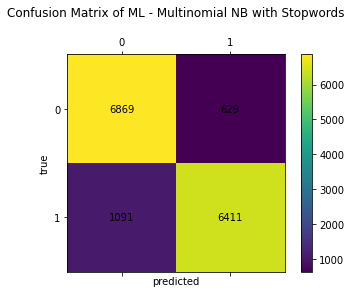

In [9]:
# ngram_range - a tuple of lower and upper boundary of range of n-values for different n-grams to be extracted
vectorizer = TfidfVectorizer(ngram_range=(1,2), use_idf=True)
train_feature = vectorizer.fit_transform(df_train['clean_sw_normalize'].ravel())     #  contiguous flattened array
train_sentiment = df_train['label']
test_feature = vectorizer.transform(df_test['clean_sw_normalize'].ravel())
test_sentiment = df_test['label']

mnb_accuracy, mnb_precision, mnb_recall, mnb_f1, mnb_pred, mnb_prob = train_model(train_feature=train_feature,
                                                                                  train_sentiment=train_sentiment,
                                                                                  test_feature=test_feature,
                                                                                  test_sentiment=test_sentiment,
                                                                                  output_model=True, 
                                                                                  output_filename='multinomialnb_with_stopwords.joblib',
                                                                                  tfidf_vectorizer=vectorizer)

print_metrics(mnb_accuracy, mnb_precision, mnb_recall, mnb_f1)
plot_title = 'Confusion Matrix of ML - Multinomial NB with Stopwords\n'
plot_confusion_matrix(test_sentiment=test_sentiment, pred=mnb_pred, plot_title=plot_title)

**Results:**
- **Label "0"** - Negative Sentiment.
- **Label "1"** - Positive Sentiment
- Correctly predicted **6869** negative sentiments. **629** of the negative sentiments were predicted to be positive sentiments.
- Correctly predicted **6411** positive sentiments. **1091** of the positive sentiments were predicted to be negative sentiments.

**Train Without Stopwords**

Performance Metrics:

|         |   accuracy |   precision |   recall |    f1 |
|---------|------------|-------------|----------|-------|
| metrics |      0.885 |       0.885 |    0.872 | 0.885 |


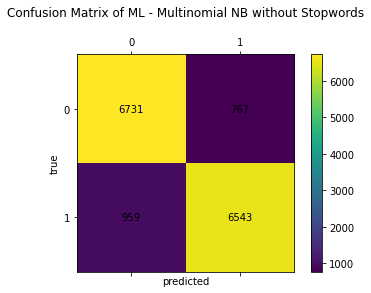

In [10]:
# ngram_range - a tuple of lower and upper boundary of range of n-values for different n-grams to be extracted
vectorizer = TfidfVectorizer(ngram_range=(1,2), use_idf=True)
train_feature = vectorizer.fit_transform(df_train['clean_nsw_normalize'].ravel())     #  contiguous flattened array
train_sentiment = df_train['label']
test_feature = vectorizer.transform(df_test['clean_nsw_normalize'].ravel())
test_sentiment = df_test['label']

mnb_accuracy, mnb_precision, mnb_recall, mnb_f1, mnb_pred, mnb_prob = train_model(train_feature=train_feature,
                                                                                  train_sentiment=train_sentiment,
                                                                                  test_feature=test_feature,
                                                                                  test_sentiment=test_sentiment,
                                                                                  output_model=True, 
                                                                                  output_filename='multinomialnb_no_stopwords.joblib', 
                                                                                  tfidf_vectorizer=vectorizer)

print_metrics(mnb_accuracy, mnb_precision, mnb_recall, mnb_f1)
plot_title = 'Confusion Matrix of ML - Multinomial NB without Stopwords\n'
plot_confusion_matrix(test_sentiment=test_sentiment, pred=mnb_pred, plot_title=plot_title)

**Results:**
- **Label "0"** - Negative Sentiment.
- **Label "1"** - Positive Sentiment
- Correctly predicted **6731** negative sentiments. **767** of the negative sentiments were predicted to be positive sentiments.
- Correctly predicted **6543** positive sentiments. **959** of the positive sentiments were predicted to be negative sentiments.

**Observations:**
- Results showed that stop words, e.g, a, the, is, are, etc. can some affect on the overall performance metrics, specifically on the precision score and recall score.
- It has a difference of 0.2% and 1.7% in the precision score and recall score, respectively, between training with stop words and without stop words.

In [ ]:
# xx = joblib.load('./multinomialnb_with_stopwords.joblib')
# vect = joblib.load('./multinomialnb_with_stopwords_vectorizer.joblib')

# a = vect.transform(['today is a day!!!'])    # must be an array
# xnew = xx.predict(a)
# probability = xx.predict_proba(a)
# print(xnew[0])
# print(probability)
# print(probability[:,xnew[0]])          # class 0 = 1st col, class 1 = 2nd col

#### BERT Approach for Sentiment Analysis

Reference: [Orhan G. Yalçın](https://towardsdatascience.com/sentiment-analysis-in-10-minutes-with-bert-and-hugging-face-294e8a04b671)

In [4]:
# pre-trained model
model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased')
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [68]:
model.summary()

Model: "tf_bert_for_sequence_classification_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_75 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
Total params: 109,483,778
Trainable params: 109,483,778
Non-trainable params: 0
_________________________________________________________________


In [69]:
# get only the require columns
df_train_bert = df_train[['bert', 'label']].copy()
df_test_bert = df_test[['bert', 'label']].copy()

In [70]:
# create sequences by converting train/test data into suitable objects for BERT model
def convert_to_examples(train: pd.DataFrame, test: pd.DataFrame) -> tuple[InputExample, InputExample]:
    train_examples = train.apply(lambda x: InputExample(guid=None, 
                                                        text_a=x['bert'].strip(), 
                                                        text_b=None, 
                                                        label=x['label']), axis=1)
    
    test_examples = test.apply(lambda x: InputExample(guid=None,
                                                      text_a=x['bert'].strip(),
                                                      text_b=None,
                                                      label=x['label']), axis=1)

    return train_examples, test_examples

In [71]:
train_examples, test_examples = convert_to_examples(df_train_bert, df_test_bert)

In [92]:
# tokenize input examples and create require input format with the tokenized objects for the model
# increase max length if have higher specs
def convert_to_tf(train_examples: list, tokenizer: BertTokenizer, max_length=64):
    features = []       # to store input features
    for example in train_examples:
        input_dict = tokenizer.__call__(
            example.text_a,
            add_special_tokens=True,
            padding='max_length',
            max_length=max_length,      # will pad to the maximum input size of the model, i.e., 512 for Bert
            return_token_type_ids=True,
            return_attention_mask=True,
            truncation=True,
        )

        input_ids, token_type_ids, attention_mask = (input_dict['input_ids'], 
                                                     input_dict['token_type_ids'],
                                                     input_dict['attention_mask'])
        features.append(InputFeatures(input_ids=input_ids, 
                                      attention_mask=attention_mask, 
                                      token_type_ids=token_type_ids,
                                      label=example.label))

    def generate() :
        for feature in features:
            yield({
                "input_ids": feature.input_ids,
                "attention_mask": feature.attention_mask,
                "token_type_ids": feature.token_type_ids,
            }, feature.label)
    
    return tf.data.Dataset.from_generator(generate,
                                          ({"input_ids": tf.int32, 
                                            "attention_mask": tf.int32, 
                                            "token_type_ids": tf.int32}, tf.int64),
                                          (
                                              {
                                                  "input_ids": tf.TensorShape([None]),
                                                  "attention_mask": tf.TensorShape([None]),
                                                  "token_type_ids": tf.TensorShape([None]),
                                              }, tf.TensorShape([]) 
                                          ))

In [96]:
# prepare train and test dataset
# increase batch size if have higher specs
train_data = convert_to_tf(list(train_examples), tokenizer)
train_data = train_data.shuffle(100).batch(16).repeat(2)

test_data = convert_to_tf(list(test_examples), tokenizer)
test_data = test_data.batch(16)

In [97]:
# train bert and using Adam as optimizer, categorical cross entropy as loss, and sparse categorical as accuracy
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5, epsilon=1e-08, clipnorm=1.0)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metrics = [tf.keras.metrics.SparseCategoricalAccuracy('accuracy')]

model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [98]:
# here can edit to save checkpoints
filepath = '[replace with your own data directory]'
callback = tf.keras.callback.ModelCheckpoint(filepath=filepath, 
                                             monitor='val_acc', 
                                             verbose=0, 
                                             save_best_only=True, 
                                             mode='auto')

model.fit(train_data, epochs=5, validation_data=test_data, callbacks=[callback])

Epoch 1/5
4376/4376 [==============================] - 3110s 704ms/step - loss: 0.3053 - accuracy: 0.8625 - val_loss: 0.4348 - val_accuracy: 0.8326
Epoch 2/5
4376/4376 [==============================] - 3074s 702ms/step - loss: 0.0731 - accuracy: 0.9737 - val_loss: 0.6425 - val_accuracy: 0.8377
Epoch 3/5
4376/4376 [==============================] - 3055s 698ms/step - loss: 0.0339 - accuracy: 0.9888 - val_loss: 0.8713 - val_accuracy: 0.8433
Epoch 4/5
4376/4376 [==============================] - 3056s 698ms/step - loss: 0.0278 - accuracy: 0.9907 - val_loss: 0.7385 - val_accuracy: 0.8457
Epoch 5/5
4376/4376 [==============================] - 3060s 699ms/step - loss: 0.0201 - accuracy: 0.9929 - val_loss: 0.8024 - val_accuracy: 0.8430


In [99]:
# save model
model.save_pretrained('.')

In [2]:
# load model
load_model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased')
load_model.load_weights('./tf_model.h5')

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [7]:
# prediction
text = "Today is a good day, maybe!"
text_token = tokenizer(text, truncation=True, padding=True, return_tensors='tf')
pred = load_model(text_token)
pred_probs = tf.nn.softmax(pred[0], axis=1).numpy()
pred_probs          # [negative, positive] prob.


array([[0.17809248, 0.8219076 ]], dtype=float32)

In [8]:
pred_label = tf.argmax(pred_probs, axis=1).numpy()
pred_label

array([1], dtype=int64)

In [ ]:
# end of file